In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install biopython

     |████████████████████████████████| 2.3MB 29.6MB/s 


In [ ]:
names = ['chr' + str(i + 1) for i in range(22)]
names.append('chrX')
names.append('chrY')

In [ ]:
!git clone --recurse-submodules https://github.com/Nazar1997/DeepZ_data_creation

Cloning into 'DeepZ_data_creation'...
remote: Enumerating objects: 1363, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1363 (delta 0), reused 0 (delta 0), pack-reused 1360
Receiving objects: 100% (1363/1363), 1.34 GiB | 19.14 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Checking out files: 100% (1140/1140), done.
Submodule 'notebooks/sparse_vector' (https://github.com/Nazar1997/Sparse_vector) registered for path 'notebooks/sparse_vector'
Cloning into '/content/DeepZ_data_creation/notebooks/sparse_vector'...
remote: Enumerating objects: 81, done.        
remote: Counting objects: 100% (81/81), done.        
remote: Compressing objects: 100% (60/60), done.        
remote: Total 81 (delta 37), reused 62 (delta 18), pack-reused 0        
Submodule path 'notebooks/sparse_vector': checked out '8a8b6292ebae6a111845b35c9d890f2fecd301af'


In [ ]:
from DeepZ_data_creation.notebooks.sparse_vector.sparse_vector import SparseVector
import DeepZ_data_creation.notebooks.sparse_vector

In [ ]:
from tqdm.notebook import tqdm
from collections import defaultdict
import numpy as np
import os
from joblib import load, dump, Parallel, delayed
import pandas as pd


In [ ]:
feature_list = sorted(os.listdir('../content/drive/MyDrive/bioinf/sparse_05'))
feature_list[:20]

['DNS.ALL.20.DNase-Seq.AllCell.pkl',
 'His.ALL.05.CENPA.AllCell.pkl',
 'His.ALL.05.H1B.AllCell.pkl',
 'His.ALL.05.H1K85ac.AllCell.pkl',
 'His.ALL.05.H1PERIOD0.AllCell.pkl',
 'His.ALL.05.H1PERIOD2.AllCell.pkl',
 'His.ALL.05.H1PERIOD4.AllCell.pkl',
 'His.ALL.05.H1PERIOD4K34ac.AllCell.pkl',
 'His.ALL.05.H1PERIOD5.AllCell.pkl',
 'His.ALL.05.H1PERIODX.AllCell.pkl',
 'His.ALL.05.H1t.AllCell.pkl',
 'His.ALL.05.H2.AllCell.pkl',
 'His.ALL.05.H2AK119Ub.AllCell.pkl',
 'His.ALL.05.H2AK120Ub.AllCell.pkl',
 'His.ALL.05.H2AK5ac.AllCell.pkl',
 'His.ALL.05.H2AK9ac.AllCell.pkl',
 'His.ALL.05.H2APERIODX.AllCell.pkl',
 'His.ALL.05.H2APERIODXS139ph.AllCell.pkl',
 'His.ALL.05.H2APERIODZ.AllCell.pkl',
 'His.ALL.05.H2APERIODZK4K7K11ac.AllCell.pkl']

In [ ]:
feature_names = []

for feature in feature_list:
    feature_name = feature.split('.')[0] + '_' + feature.split('.')[3]
    feature_names.append(feature_name)

In [ ]:
features = {}

for i, feature in enumerate(tqdm(feature_list)):
    features[feature_names[i]] = load("/content/drive/MyDrive/bioinf/sparse_05/" + feature)

In [ ]:
print(feature_names[:5])

['DNS_DNase-Seq', 'His_CENPA', 'His_H1B', 'His_H1K85ac', 'His_H1PERIOD0']


In [ ]:
positive_samples_file = '/content/drive/MyDrive/bioinf/GSM3417036_TriplexDNASeq_plus_RNA_ligation.bed'

In [ ]:
!apt-get install bedtools
!pip install pybedtools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 577 kB of archives.
After this operation, 2,040 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 bedtools amd64 2.26.0+dfsg-5 [577 kB]
Fetched 577 kB in 1s (521 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../bedtools_2.26.0+dfsg-5_amd64.deb ...
Unpacking bedtools (2.26.0+dfsg-5) ...
Setting up bedtools (2.26.0+dfsg-5) ...
     |████████████████████████████████| 12.5MB 264kB/s 
     |████████████████████████████████| 9.9MB 29.1MB/s 
  Created wheel for pybedtools: filename

In [ ]:
from pybedtools import BedTool

In [ ]:
positive_samples = BedTool(positive_samples_file)

In [ ]:
from Bio import SeqIO

chroms = {}

for name in tqdm(names):
    chroms[name] = SeqIO.read('/content/drive/MyDrive/bioinf/hg38/' + name + '.fa', 'fasta')

In [ ]:
def count_features(start, end, chrom):
    res = []
    for feature_name in feature_list:
        cur = [0, 0, 0]
        if chrom in features[feature_name].keys():
            if np.any(features[feature_name][chrom][start:end]):
                cur = [1, np.count_nonzero(features[feature_name][chrom][start:end]),
                       np.sum(features[feature_name][chrom][start:end]) / 1000]
        res.append(np.array(cur))
    return np.array(res)


In [ ]:
sum_len = 0

for record in positive_samples:
    sum_len += record.end - record.start
print(sum_len)
print(sum_len / len(positive_samples))

1767700
694.0321947389085


In [ ]:
summary = np.zeros((len(feature_names), 3))
used_positions = {}

for name in names:
    used_positions[name] = set()

for record in tqdm(positive_samples):
    #print(count_features(record.start, record.end, record.chrom))
    summary += count_features(record.start, record.end, record.chrom)
    used_positions[record.chrom].update(set(range(record.start, record.end)))

print(summary[:2])


[[8.03000000e+02 2.12314000e+05 1.49235688e+05]
 [1.17000000e+02 4.66260000e+04 2.04164150e+04]]


In [ ]:
from random import choice, randrange

rand_summary = np.zeros((len(feature_names), 3))
rand_counter = 0

for i in tqdm(range(len(positive_samples) * 10)):
    chrom = choice(names)
    start = randrange(len(chroms[chrom]) - 694)
    end = start + 694
    while not used_positions[chrom].isdisjoint(set(range(start, end))) or chroms[chrom][start:end].seq.count('N') / 694 >= 0.01:
        chrom = choice(names)
        start = randrange(len(chroms[chrom]) - 694)
        end = start + 694
    used_positions[chrom].update(set(range(start, end)))
    rand_summary += count_features(start, end, chrom)

rand_summary /= 10
print(rand_summary[:2])


[[6.69500000e+02 1.33398900e+05 8.11045944e+04]
 [2.52000000e+01 5.59090000e+03 1.40353280e+03]]


In [ ]:
diffs = np.abs(summary - rand_summary)

(array([ 41., 212., 185., 230., 112., 115.,  83.,  73.,  40.,  26.,   7.,
          4.,   3.,   2.,   3.,   3.,   2.,   1.,   2.,   2.]),
 array([  1.   ,  24.115,  47.23 ,  70.345,  93.46 , 116.575, 139.69 ,
        162.805, 185.92 , 209.035, 232.15 , 255.265, 278.38 , 301.495,
        324.61 , 347.725, 370.84 , 393.955, 417.07 , 440.185, 463.3  ]),
 <a list of 20 Patch objects>)

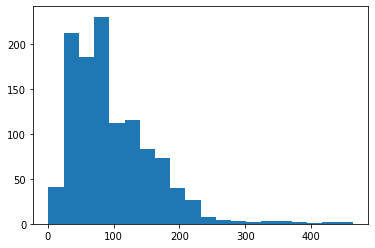

In [ ]:
import matplotlib.pyplot as plt

plt.hist(diffs[:, 0], bins=20)

(array([231., 305., 218., 129.,  93.,  65.,  48.,  22.,  15.,   2.,   3.,
          3.,   5.,   1.,   1.,   2.,   0.,   1.,   1.,   1.]),
 array([   496.  ,  13789.55,  27083.1 ,  40376.65,  53670.2 ,  66963.75,
         80257.3 ,  93550.85, 106844.4 , 120137.95, 133431.5 , 146725.05,
        160018.6 , 173312.15, 186605.7 , 199899.25, 213192.8 , 226486.35,
        239779.9 , 253073.45, 266367.  ]),
 <a list of 20 Patch objects>)

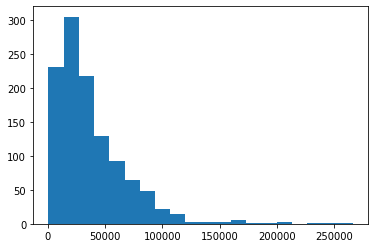

In [ ]:
plt.hist(diffs[:, 1], bins=20)

(array([425., 305., 160.,  97.,  62.,  35.,  22.,  13.,  12.,   1.,   2.,
          2.,   2.,   3.,   0.,   1.,   1.,   1.,   1.,   1.]),
 array([1.12019900e+02, 8.54526944e+03, 1.69785190e+04, 2.54117685e+04,
        3.38450180e+04, 4.22782676e+04, 5.07115171e+04, 5.91447666e+04,
        6.75780162e+04, 7.60112657e+04, 8.44445153e+04, 9.28777648e+04,
        1.01311014e+05, 1.09744264e+05, 1.18177513e+05, 1.26610763e+05,
        1.35044012e+05, 1.43477262e+05, 1.51910512e+05, 1.60343761e+05,
        1.68777011e+05]),
 <a list of 20 Patch objects>)

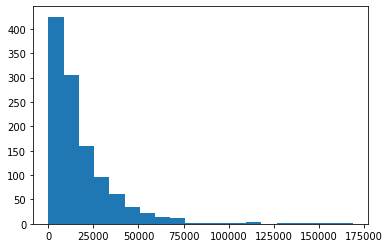

In [ ]:
plt.hist(diffs[:, 2], bins=20)

In [ ]:
sub_feature_names = []
t_0 = np.percentile(diffs[:,0], 66)
t_1 = np.percentile(diffs[:,1], 66)
t_2 = np.percentile(diffs[:,2], 66)


for i in range(len(diffs)):
    if diffs[i][0] >= t_0 and diffs[i][1] >= t_1 and diffs[i][2] >= t_2:
        sub_feature_names.append(feature_names[i])

In [ ]:
print(len(sub_feature_names))
print(sub_feature_names[:10])

320
['DNS_DNase-Seq', 'His_H2AK119Ub', 'His_H2APERIODXS139ph', 'His_H2APERIODZ', 'His_H2APERIODZK4K7K11ac', 'His_H2APERIODZac', 'His_H2BK120ac', 'His_H2BK5ac', 'His_H3', 'His_H3K122ac']


In [ ]:
dump(sub_feature_names, '/content/drive/MyDrive/bioinf/sub_names.pkl', 3)
dump(diffs, '/content/drive/MyDrive/bioinf/diffs.pkl', 3)

['/content/drive/MyDrive/bioinf/diffs.pkl']

In [ ]:
sub_feature_names = load('/content/drive/MyDrive/bioinf/sub_names.pkl')
diffs = load('/content/drive/MyDrive/bioinf/diffs.pkl')

In [ ]:
input_len = 800

In [ ]:
import scipy
from scipy.sparse import csr_matrix

In [ ]:
def seq_to_features(seq, start, end, strand, chrom):
    cur = np.zeros((len(seq), 4 + len(sub_feature_names)))
    for i, nuc in enumerate(seq):
        if nuc.lower() == 'a':
            cur[i][0] = 1
        elif nuc.lower() == 't':
            cur[i][1] = 1
        elif nuc.lower() == 'g':
            cur[i][2] = 1
        elif nuc.lower() == 'c':
            cur[i][3] = 1
    for i, feature_name in enumerate(sub_feature_names):
        if chrom in features[feature_name].keys():
            if strand == '-':
                cur[:,i+4] = features[feature_name][chrom][start:end][::-1] / 1000
            else:
                cur[:,i+4] = features[feature_name][chrom][start:end] / 1000
    return csr_matrix(cur)

In [ ]:
import math

def get_subseq(start, end, strand, chrom, subseq_len=input_len, share=10):
    
    if end - start > subseq_len:
        output = []

        n = math.ceil(((end - start) * share - subseq_len) / (subseq_len * (share - 1)))
        begin = start - (((share - 1) * n + 1) * subseq_len // share - (end - start)) // 2
        
        while begin <= end:

            nuc_seq = ''
            if strand == '-':
                nuc_seq = str(chroms[chrom][begin:begin+subseq_len].seq.reverse_complement())
            else:
                nuc_seq = str(chroms[chrom][begin:begin+subseq_len].seq)
                
            output.append(seq_to_features(nuc_seq, begin, begin + subseq_len, strand, chrom))
                            
            begin += subseq_len - subseq_len // share
        
        return output
    
    
    left_add = (subseq_len - abs(end - start)) // 2
    right_add = subseq_len - abs(end - start) - left_add
    nuc_seq = ''

    if strand == '-':
        nuc_seq = str(chroms[chrom][start - left_add:end + right_add].seq.reverse_complement())
    else:
        nuc_seq = str(chroms[chrom][start - left_add:end + right_add].seq)
        
    return [seq_to_features(nuc_seq, start - left_add, end + right_add, strand, chrom)]
        


In [ ]:
example = positive_samples[0]
get_subseq(example.start, example.end, example.strand, example.chrom)

[<800x240 sparse matrix of type '<class 'numpy.float64'>'
 	with 130105 stored elements in Compressed Sparse Row format>]

In [ ]:
positive_data = []
used_positions = {}

for name in names:
    used_positions[name] = set()

for record in tqdm(positive_samples):
    if chroms[record.chrom][record.start:record.end].seq.count('N') / input_len < 0.01:
        positive_data.extend(get_subseq(record.start, record.end,
                                        record.strand, record.chrom, subseq_len=input_len + input_len // 2))
        used_positions[record.chrom].update(set(range(record.start, record.end)))


In [ ]:
from random import choice, randrange
 
num_of_random_seqs = len(positive_data)
 
random_seqs = []
 
for i in tqdm(range(num_of_random_seqs)):
    chrom = choice(names)
    start = randrange(len(chroms[chrom]) - input_len)
    end = start + input_len
    strand = choice([0, 1])
    while chroms[chrom][start:end].seq.count('N') / input_len >= 0.01 or not used_positions[chrom].isdisjoint(set(range(start, end))):
        chrom = choice(names)
        start = randrange(len(chroms[chrom]) - input_len)
        end = start + input_len
        strand = choice([0, 1])
    used_positions[chrom].update(set(range(start, end)))
    if strand == 1:
        random_seqs.extend(get_subseq(start, end, '+', chrom, subseq_len=input_len + input_len // 2))
    else:
        random_seqs.extend(get_subseq(start, end, '-', chrom, subseq_len=input_len + input_len // 2))

In [ ]:
dump(positive_data, '/content/drive/MyDrive/bioinf/positive_05_sub.pkl', 3)
dump(random_seqs, '/content/drive/MyDrive/bioinf/random_05_sub.pkl', 3)

['/content/drive/MyDrive/bioinf/random_05_sub.pkl']

In [ ]:
positive_data = load('/content/drive/MyDrive/bioinf/positive_05_sub.pkl')
random_seqs = load('/content/drive/MyDrive/bioinf/random_05_sub.pkl')

In [ ]:
del chroms

In [ ]:
y = [1 for seq in positive_data]
y.extend([0 for seq in random_seqs])

In [ ]:
X = positive_data
X.extend(random_seqs)

In [ ]:
X = np.array(X)

In [ ]:
X.shape

(5666,)

In [ ]:
y = np.array(y)
y.shape

(5666,)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=77)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, LeakyReLU, Conv1D, GlobalMaxPool1D, MaxPooling1D, Input
from tensorflow.keras.initializers import random_normal
from tensorflow.keras.regularizers import L2
import tensorflow as tf
 
filters = 30
kernel_size = 20
sd = 0.1
pool_size = 15
strides = 5
l2_weight = 0
dropout = 0.15
alpha = 0.3
padding='same'
 
def make_model_CNN():
    model = Sequential()
    #model.add(Input(shape=(input_len, 4 + len(feature_names)), sparse=True))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, input_shape=(input_len, 4 + len(sub_feature_names)),
                     kernel_initializer=random_normal(stddev=sd), kernel_regularizer=L2(l2_weight), padding=padding))
    model.add(LeakyReLU(alpha=alpha))
    model.add(MaxPooling1D(pool_size=pool_size, strides=strides, padding=padding))
    model.add(Dropout(dropout))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                     kernel_initializer=random_normal(stddev=sd), kernel_regularizer=L2(l2_weight)))
    model.add(LeakyReLU(alpha=alpha))
    model.add(MaxPooling1D(pool_size=10, strides=2, padding=padding))
    model.add(Dropout(dropout))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(dropout))
    model.add(Dense(10, kernel_initializer=random_normal(stddev=sd), kernel_regularizer=L2(l2_weight)))
    model.add(Dropout(dropout))
    model.add(Dense(1, kernel_initializer=random_normal(stddev=sd), kernel_regularizer=L2(l2_weight)))
    model.add(Activation("sigmoid"))
    
    return model

In [ ]:
model = make_model_CNN()

In [ ]:
dna_indices = list(range(4))
dns_indices = []
his_indices = []
oth_indices = []
pol_indices = []

for i, feature_name in enumerate(sub_feature_names):
    if feature_name.startswith('DNS'):
        dns_indices.append(i+4)
    elif feature_name.startswith('His'):
        his_indices.append(i+4)
    elif feature_name.startswith('Oth'):
        oth_indices.append(i+4)
    elif feature_name.startswith('Pol'):
        pol_indices.append(i+4)
    else:
        print(feature_name[:4])

print(np.min(dna_indices))
print(np.max(dna_indices))
print(len(dns_indices))
print(len(his_indices))
print(len(pol_indices))
print(len(oth_indices))

0
3
1
40
6
273


In [ ]:
def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    if curr_session is not None:
        curr_session.close()
    tf.keras.backend.clear_session()
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
    tf.compat.v1.keras.backend.set_session(s)
    return s

In [ ]:
from random import randrange
import math
 
def batch_generator(X, y, batch_size, train=False):
    number_of_batches = X.shape[0] // batch_size
    if number_of_batches != math.ceil(X.shape[0] / batch_size):
        number_of_batches += 1
    counter = 0
    shuffle_index = np.arange(len(y))
    if train: 
        np.random.shuffle(shuffle_index)
    while 1:
        index_batch = shuffle_index[batch_size * counter : min(batch_size * (counter + 1), len(shuffle_index))]
        if train:
            X_batch = []
            for x in X[index_batch]:
                shift = randrange(400)
                X_batch.append(np.array(x.todense())[shift:shift+input_len])
        else:
            X_batch = [np.array(x.todense())[200:1000] for x in X[index_batch]]
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch), y_batch)
        if (counter >= number_of_batches):
            if train:
                np.random.shuffle(shuffle_index)
            counter = 0

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, LeakyReLU, Conv1D, GlobalMaxPool1D, MaxPooling1D, Input
from tensorflow.keras.layers import Lambda, Concatenate, Reshape, Cropping1D, ReLU
from tensorflow.keras.initializers import random_normal
from tensorflow.keras.regularizers import L2, L1
import tensorflow as tf
 
 
 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
s = reset_tf_session()
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 30
 
bst_loss = [0.5519489645957947, 0.7319223880767822, 0.7997028231620789]
bst_acc = [0.5524182319641113, 0.7345678806304932, 0.796713650226593]
bst_auc = [0.5538930296897888, 0.7213403582572937, 0.8112582564353943]
 
#used = []
#dump(used, '/content/drive/My Drive/bioinf/' + 'used.pkl', 3)
used = load('/content/drive/My Drive/bioinf/' + 'used.pkl')
 
 
for strides in [(4, 4), (4, 5), (5, 5)]:
    for poolsizes in [(5, 20), (10, 30), (15, 40)]:
        for filters in [(20, 3, 5, 10), (25, 5, 10, 15), (30, 7, 15, 20)]:
            for filtersizes in [(10, 5), (15, 5), (20, 10)]:
                for dropouts in [(0.1, 0.2, 0.3, 0.5), (0.2, 0.3, 0.5, 0.75), (0.3, 0.5, 0.75, 0.9)]:
                    
                    if [strides, poolsizes, filters, filtersizes, dropouts] not in used:
 
                        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
                        s = reset_tf_session()
 
                        input = Input(shape=(input_len, 4 + len(sub_feature_names)))
 
                        dna = Lambda(lambda x: x[:, :, np.min(dna_indices):np.min(dna_indices)+len(dna_indices)])(input)
                        conv1 = Conv1D(filters=filters[0], kernel_size=filtersizes[0], kernel_initializer=random_normal(stddev=0.1), padding='same')(dna)
                        relu1 = ReLU()(conv1)
                        pool1 = MaxPooling1D(pool_size=poolsizes[0], strides=strides[0], padding='same')(relu1)
                        dropout1 = Dropout(dropouts[0])(pool1)
                        conv2 = Conv1D(filters=filters[0], kernel_size=filtersizes[0], kernel_initializer=random_normal(stddev=0.1), padding='same')(pool1)
                        relu2 = ReLU()(conv2)
                        pool2 = MaxPooling1D(pool_size=poolsizes[0], strides=strides[1], padding='same')(relu2)
                        dropout2 = Dropout(dropouts[0])(pool2)
 
                        dns = Lambda(lambda x: x[:, :, np.min(dns_indices):np.min(dns_indices)+len(dns_indices)])(input)
                        conv_dns = Conv1D(filters=filters[1], kernel_size=filtersizes[0], kernel_initializer=random_normal(stddev=0.1), padding='same')(dns)
                        relu_dns = ReLU()(conv_dns)
                        pool_dns = MaxPooling1D(pool_size=30, strides=strides[0]*strides[1], padding='same')(relu_dns)
                        dropout_dns = Dropout(dropouts[1])(pool_dns)
 
                        pol = Lambda(lambda x: x[:, :, np.min(pol_indices):np.min(pol_indices)+len(pol_indices)])(input)
                        conv_pol = Conv1D(filters=filters[2], kernel_size=filtersizes[0], kernel_initializer=random_normal(stddev=0.1), padding='same')(pol)
                        relu_pol = ReLU()(conv_pol)
                        pool_pol = MaxPooling1D(pool_size=poolsizes[1], strides=strides[0]*strides[1], padding='same')(relu_pol)
                        dropout_pol = Dropout(dropouts[1])(pool_pol)
 
                        his = Lambda(lambda x: x[:, :, np.min(his_indices):np.min(his_indices)+len(his_indices)])(input)
                        conv_his = Conv1D(filters=filters[2], kernel_size=filtersizes[0], kernel_initializer=random_normal(stddev=0.1), padding='same')(his)
                        relu_his = ReLU()(conv_his)
                        pool_his = MaxPooling1D(pool_size=poolsizes[1], strides=strides[0]*strides[1], padding='same')(relu_his)
                        dropout_his = Dropout(dropouts[2])(pool_his)
 
                        oth = Lambda(lambda x: x[:, :, np.min(oth_indices):np.min(oth_indices)+len(oth_indices)])(input)
                        conv_oth = Conv1D(filters=filters[3], kernel_size=filtersizes[0], kernel_initializer=random_normal(stddev=0.1), padding='same')(oth)
                        relu_oth = ReLU()(conv_oth)
                        pool_oth = MaxPooling1D(pool_size=poolsizes[1], strides=strides[0]*strides[1], padding='same')(relu_oth)
                        dropout_oth = Dropout(dropouts[3])(pool_oth)
 
                        concat = Concatenate(axis=2)([dropout2, dropout_dns, dropout_pol, dropout_his, dropout_oth])
                        conv_concat = Conv1D(filters=filters[1], kernel_size=filtersizes[1], kernel_initializer=random_normal(stddev=0.1), padding='same')(concat)
                        relu_concat = ReLU()(conv_concat)
                        pool_concat = MaxPooling1D(pool_size=poolsizes[0], strides=5, padding='same')(relu_concat)
                        dropout_concat = Dropout(dropouts[3])(pool_concat)
 
                        dna_maxpool = GlobalMaxPool1D()(dropout2)
                        dna_pred = Dense(1)(dna_maxpool)
 
                        dns_maxpool = GlobalMaxPool1D()(dropout_dns)
                        dns_pred = Dense(1)(dns_maxpool)
 
                        pol_maxpool = GlobalMaxPool1D()(dropout_pol)
                        pol_pred = Dense(1)(pol_maxpool)
 
                        his_maxpool = GlobalMaxPool1D()(dropout_his)
                        his_pred = Dense(1)(his_maxpool)
 
                        oth_maxpool = GlobalMaxPool1D()(dropout_oth)
                        oth_pred = Dense(1)(oth_maxpool)
 
                        concat_maxpool = GlobalMaxPool1D()(dropout_concat)
                        concat_pred = Dense(1)(concat_maxpool)
 
                        preds = Concatenate()([dna_pred, dns_pred, pol_pred, his_pred, oth_pred, concat_pred])
                        dropout_preds = Dropout(dropouts[1])(preds)
                        pred_comb = Dense(1)(preds)
                        output = Activation("sigmoid")(pred_comb)
 
                        model = Model(inputs=input, outputs=output)
 
                        bst_model_path = 'CNN_omics' + '.h5'
                        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
 
                        model.compile(
                            loss='binary_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
                            metrics=['accuracy', tf.keras.metrics.AUC()]
                        )
 
                        def lr_scheduler(epoch):
                            return INIT_LR * 0.9 ** epoch
  
                        model.fit(
                            batch_generator(X_train, y_train, BATCH_SIZE, train=True),
                            epochs=EPOCHS,
                            steps_per_epoch=X_train.shape[0] // BATCH_SIZE + 1,
                            callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
                            validation_data=batch_generator(X_test, y_test, BATCH_SIZE),
                            validation_steps=X_test.shape[0] // BATCH_SIZE + 1,
                            verbose=0,
                            initial_epoch=0
                        )
                    
                        model.load_weights(bst_model_path)
 
                        metrics = model.evaluate(batch_generator(X_test, y_test, BATCH_SIZE), steps=X_test.shape[0] // BATCH_SIZE + 1)
 
                        if metrics[0] < bst_loss[0]:
                            bst_loss = metrics
                        if metrics[1] > bst_acc[1]:
                            bst_acc = metrics
                        if metrics[2] > bst_auc[2]:
                            bst_auc = metrics
                    
                        print(strides)
                        print(poolsizes)
                        print(filters)
                        print(filtersizes)
                        print(dropouts)
                        print()
                        print(metrics)
                        print()
                        print(bst_loss)
                        print(bst_acc)
                        print(bst_auc)
                        print()
 
                        f = open('/content/drive/My Drive/bioinf/' + 'test_results.txt', 'a')
 
                        f.write(str(strides) + '\n')
                        f.write(str(poolsizes) + '\n')
                        f.write(str(filters) + '\n')
                        f.write(str(filtersizes) + '\n')
                        f.write(str(dropouts) + '\n')
                        f.write(str(metrics) + '\n')
 
                        f.close()
 
                        used.append([strides, poolsizes, filters, filtersizes, dropouts])
                        dump(used, '/content/drive/My Drive/bioinf/' + 'used.pkl', 3)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = 42, shuffle=True)

In [ ]:
!mkdir ../content/drive/MyDrive/bioinf/loss
!mkdir ../content/drive/MyDrive/bioinf/acc
!mkdir ../content/drive/MyDrive/bioinf/auc

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, LeakyReLU, Conv1D, GlobalMaxPool1D, MaxPooling1D, Input
from tensorflow.keras.layers import Lambda, Concatenate, Reshape, Cropping1D, ReLU
from tensorflow.keras.initializers import random_normal
from tensorflow.keras.regularizers import L2, L1
import tensorflow as tf
 
s = reset_tf_session()
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 50
 
bst_loss = [0.54742585, 0.7274958, 0.7977035]
bst_acc = [0.54742585, 0.7274958, 0.7977035]
bst_auc = [0.54742585, 0.7274958, 0.7977035]
 
for neurons in [30, 40, 50, 60]:
    for dropout in [0.9]:
 
        metrics = np.zeros(3)
        counter = 0
 
        for train, test in kf.split(X):
                                
            X_train = X[train]
            y_train = y[train]
                                
            X_test = X[test]
            y_test = y[test]
 
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
            s = reset_tf_session()
 
            input = Input(shape=(input_len, 4 + len(sub_feature_names)))
 
            dna = Lambda(lambda x: x[:, :, np.min(dna_indices):np.min(dna_indices)+len(dna_indices)])(input)
            conv1 = Conv1D(filters=30, kernel_size=10, kernel_initializer=random_normal(stddev=0.1), padding='same')(dna)
            relu1 = ReLU()(conv1)
            pool1 = MaxPooling1D(pool_size=5, strides=4, padding='same')(relu1)
            dropout1 = Dropout(0.2)(pool1)
            conv2 = Conv1D(filters=30, kernel_size=10, kernel_initializer=random_normal(stddev=0.1), padding='same')(pool1)
            relu2 = ReLU()(conv2)
            pool2 = MaxPooling1D(pool_size=5, strides=4, padding='same')(relu2)
            dropout2 = Dropout(0.3)(pool2)
 
            dns = Lambda(lambda x: x[:, :, np.min(dns_indices):np.min(dns_indices)+len(dns_indices)])(input)
            conv_dns = Conv1D(filters=7, kernel_size=10, kernel_initializer=random_normal(stddev=0.1), padding='same')(dns)
            relu_dns = ReLU()(conv_dns)
            pool_dns = MaxPooling1D(pool_size=20, strides=16, padding='same')(relu_dns)
            dropout_dns = Dropout(0.3)(pool_dns)
 
            pol = Lambda(lambda x: x[:, :, np.min(pol_indices):np.min(pol_indices)+len(pol_indices)])(input)
            conv_pol = Conv1D(filters=15, kernel_size=10, kernel_initializer=random_normal(stddev=0.1), padding='same')(pol)
            relu_pol = ReLU()(conv_pol)
            pool_pol = MaxPooling1D(pool_size=20, strides=16, padding='same')(relu_pol)
            dropout_pol = Dropout(0.5)(pool_pol)
 
            his = Lambda(lambda x: x[:, :, np.min(his_indices):np.min(his_indices)+len(his_indices)])(input)
            conv_his = Conv1D(filters=15, kernel_size=10, kernel_initializer=random_normal(stddev=0.1), padding='same')(his)
            relu_his = ReLU()(conv_his)
            pool_his = MaxPooling1D(pool_size=20, strides=16, padding='same')(relu_his)
            dropout_his = Dropout(0.75)(pool_his)
 
            oth = Lambda(lambda x: x[:, :, np.min(oth_indices):np.min(oth_indices)+len(oth_indices)])(input)
            conv_oth = Conv1D(filters=20, kernel_size=10, kernel_initializer=random_normal(stddev=0.1), padding='same')(oth)
            relu_oth = ReLU()(conv_oth)
            pool_oth = MaxPooling1D(pool_size=20, strides=16, padding='same')(relu_oth)
            dropout_oth = Dropout(0.9)(pool_oth)
 
            omics_sum = Lambda(lambda x: tf.keras.backend.sum(x[:, :, 4:] / 100, axis=1))(input)
            dense_omics = Dense(neurons)(omics_sum)
            relu_omics = ReLU()(dense_omics)
            dropout_omics = Dropout(dropout)(relu_omics)
            pred_omics = Dense(1)(dropout_omics)
 
            concat = Concatenate(axis=2)([dropout2, dropout_dns, dropout_pol, dropout_his, dropout_oth])
            conv_concat = Conv1D(filters=7, kernel_size=5, kernel_initializer=random_normal(stddev=0.1), padding='same')(concat)
            relu_concat = ReLU()(conv_concat)
            pool_concat = MaxPooling1D(pool_size=5, strides=5, padding='same')(relu_concat)
            dropout_concat = Dropout(0.9)(pool_concat)
 
            dna_maxpool = GlobalMaxPool1D()(dropout2)
            dna_pred = Dense(1)(dna_maxpool)
 
            dns_maxpool = GlobalMaxPool1D()(dropout_dns)
            dns_pred = Dense(1)(dns_maxpool)
 
            pol_maxpool = GlobalMaxPool1D()(dropout_pol)
            pol_pred = Dense(1)(pol_maxpool)
 
            his_maxpool = GlobalMaxPool1D()(dropout_his)
            his_pred = Dense(1)(his_maxpool)
 
            oth_maxpool = GlobalMaxPool1D()(dropout_oth)
            oth_pred = Dense(1)(oth_maxpool)
 
            concat_maxpool = GlobalMaxPool1D()(dropout_concat)
            concat_pred = Dense(1)(concat_maxpool)
 
            preds = Concatenate()([dna_pred, dns_pred, pol_pred, his_pred, oth_pred, concat_pred, pred_omics])
            dropout_preds = Dropout(0.5)(preds)
            pred_comb = Dense(1)(preds)
            output = Activation("sigmoid")(pred_comb)
 
            model = Model(inputs=input, outputs=output) 
 
            bst_model_path = 'CNN_omics_' + str(counter) + '.h5'
            model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, monitor = 'val_loss',
                                                                  save_best_only=True, save_weights_only=False)
                                
            model.compile(
                loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
                metrics=['accuracy', tf.keras.metrics.AUC()]
            )
 
            def lr_scheduler(epoch):
                return INIT_LR * 0.9 ** epoch
        
            model.fit(
                batch_generator(X_train, y_train, BATCH_SIZE, train=True),
                epochs=EPOCHS,
                steps_per_epoch=X_train.shape[0] // BATCH_SIZE + 1,
                callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
                validation_data=batch_generator(X_test, y_test, BATCH_SIZE),
                validation_steps=X_test.shape[0] // BATCH_SIZE + 1,
                verbose=0,
                initial_epoch=0
            )
 
            model = tf.keras.models.load_model(bst_model_path)
 
            metrics += np.array(model.evaluate(batch_generator(X_test, y_test, BATCH_SIZE), steps=X_test.shape[0] // BATCH_SIZE + 1))
 
            counter += 1
 
        metrics = metrics / 5
        print()
        print(neurons)
        print(dropout)              
        print(metrics)
        print()
 
        if metrics[0] < bst_loss[0]:
            bst_loss = metrics
            for i in range(5):
                name = 'CNN_omics_' + str(i) + '.h5'
                os.system('cp ' + name + ' ../content/drive/MyDrive/bioinf/loss/' + name)
        if metrics[1] > bst_acc[1]:
            bst_acc = metrics
            for i in range(5):
                name = 'CNN_omics_' + str(i) + '.h5'
                os.system('cp ' + name + ' ../content/drive/MyDrive/bioinf/acc/' + name)
        if metrics[2] > bst_auc[2]:
            bst_auc = metrics
            for i in range(5):
                name = 'CNN_omics_' + str(i) + '.h5'
                os.system('cp ' + name + ' ../content/drive/MyDrive/bioinf/auc/' + name)
 
        print(bst_loss)
        print(bst_acc)
        print(bst_auc)
        print()

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, LeakyReLU, Conv1D, GlobalMaxPool1D, MaxPooling1D, Input
from tensorflow.keras.layers import Lambda, Concatenate, Reshape, Cropping1D, ReLU
from tensorflow.keras.initializers import random_normal
from tensorflow.keras.regularizers import L2, L1
import tensorflow as tf
 
def inverse_sigmoid(y):
    return - np.log((1-y)/y)

In [ ]:

 
values = []
 
for j in tqdm(range(len(sub_feature_names))):
    cur = []
    for i in range(5):
        model = tf.keras.models.load_model('../content/drive/MyDrive/bioinf/loss/' + 'CNN_omics_' + str(i) + '.h5')
        x = np.zeros((800, len(sub_feature_names)+4))
        x[:, 4 + j] = np.ones(800)
        cur.append(inverse_sigmoid(model(np.array([x])).numpy()[0][0]))
    cur = np.array(cur)
    if np.all(cur >= 0):
        values.append(np.min(cur))
    elif np.all(cur <= 0):
        values.append(np.max(cur))
    else:
        values.append(0)

In [ ]:
values = np.array(values)

In [ ]:
dump(values, '../content/drive/MyDrive/bioinf/values.pkl', 3)

['../content/drive/MyDrive/bioinf/values.pkl']

In [ ]:
values = load('../content/drive/MyDrive/bioinf/values.pkl')

In [ ]:
for i in np.argsort(values)[:15]:
    print(sub_feature_names[i])
    print(values[i])
    print()
print()
for i in np.argsort(values)[:-15:-1]:
    print(sub_feature_names[i])
    print(values[i])
    print()

In [ ]:
neg_max = []
pos_max = []
 
def from_ind_to_letter(i):
    if i == 0:
        return 'A'
    if i == 1:
        return 'T'
    if i == 2:
        return 'G'
    if i == 3:
        return 'C'
 
for i in range(5):
    model = tf.keras.models.load_model('../content/drive/MyDrive/bioinf/loss/' + 'CNN_omics_' + str(i) + '.h5')
    cur_neg_max = []
    cur_pos_max = []
    for j in range(model.layers[2].weights[0].numpy().shape[2]):
        filter = model.layers[2].weights[0].numpy()[:,:,j]
        cur_neg = 0
        cur_pos = 0
        cur_neg_motif = ''
        cur_pos_motif = ''
        for pos in filter:
            if np.max(pos) > 0.05:
                cur_pos += np.max(pos)
                cur_pos_motif = cur_pos_motif + from_ind_to_letter(np.argmax(pos))
            else:
                cur_pos_motif = cur_pos_motif + '-'
            if np.min(pos) < - 0.05:
                cur_neg += np.min(pos)
                cur_neg_motif = cur_neg_motif + from_ind_to_letter(np.argmin(pos))
            else:
                cur_neg_motif = cur_neg_motif + '-'
        cur_neg_max.append((j, cur_neg, cur_neg_motif))
        cur_pos_max.append((j, cur_pos, cur_pos_motif))
    pos_max.append([cur_pos_max[k] for k in np.argsort(np.array([x[1] for x in cur_pos_max]))[-3:]])
    neg_max.append([cur_neg_max[k] for k in np.argsort(np.array([x[1] for x in cur_neg_max]))[:3]])
 
print(pos_max)
print(neg_max)

[[(15, 1.7735652774572372, 'GCCTACGATT'), (13, 1.8740838430821896, 'GGTCGTGGT-'), (26, 1.9125818982720375, 'GACTCGAGC-')], [(7, 1.5820410251617432, 'ACATTTG-CC'), (2, 1.6244314536452293, 'CAT-AAAAAT'), (8, 1.9158712700009346, 'AATACAACCA')], [(1, 1.8158085197210312, 'TAGCACTTAT'), (17, 1.8493582643568516, 'C-GGTGGAGT'), (20, 1.8910151571035385, 'GAATGTGC-C')], [(26, 2.0463351011276245, 'GAGTTGGAGA'), (16, 2.144546091556549, 'GTACCCTCTA'), (0, 2.493312433362007, 'GTGGCGGCTG')], [(22, 2.0508105009794235, 'GAATTAGAAC'), (12, 2.200961656868458, 'A-GTG-TGTC'), (17, 2.287252701818943, 'ACTGGGACAT')]]
[[(17, -2.6729113459587097, 'CTAGGTGTAA'), (9, -2.633921191096306, 'CACTACGTAC'), (16, -2.6007568016648293, 'CATGAGCAAT')], [(8, -3.5366570726037025, 'CGATATCAGG'), (9, -3.2966136038303375, 'CAAATACTAC'), (13, -3.2187427952885628, 'GCTGTTTCGT')], [(17, -3.311016947031021, 'AATAGTACAA'), (23, -3.1568370312452316, 'AGTCCGCTAT'), (26, -2.9047449231147766, 'TGTACTCTTA')], [(16, -3.9146843999624252, 

In [ ]:
pos_max[0]

[(15, 1.7735652774572372, 'GCCTACGATT'),
 (13, 1.8740838430821896, 'GGTCGTGGT-'),
 (26, 1.9125818982720375, 'GACTCGAGC-')]

In [ ]:
def from_motif_to_input(motif):
    x = np.zeros((800, 4+len(sub_feature_names)))
    for i in range(800):
        cur = motif[i % len(motif)]
        if cur == 'A':
            x[i][0] = 1
        elif cur == 'T':
            x[i][1] = 1
        elif cur == 'G':
            x[i][2] = 1
        elif cur == 'C':
            x[i][3] = 1
    return x

In [ ]:
for motives in pos_max:
    for motif in motives:
        cur = []
        for i in range(5):
            model = tf.keras.models.load_model('../content/drive/MyDrive/bioinf/loss/' + 'CNN_omics_' + str(i) + '.h5')
            cur.append(inverse_sigmoid(model(np.array([from_motif_to_input(motif[2])]))[0][0]))
        print(motif[2])
        cur = np.array(cur)
        if np.all(cur >= 0):
            print(np.min(cur))
        elif np.all(cur <= 0):
            print(np.max(cur))
        else:
            print(0)
        print()

GCCTACGATT
-0.5145577

GGTCGTGGT-
0.5328543

GACTCGAGC-
0

ACATTTG-CC
-0.5200967

CAT-AAAAAT
-1.2004987

AATACAACCA
0

TAGCACTTAT
-2.0805247

C-GGTGGAGT
0.089564756

GAATGTGC-C
0

GAGTTGGAGA
0

GTACCCTCTA
0

GTGGCGGCTG
0.632115

GAATTAGAAC
-0.42549527

A-GTG-TGTC
0

ACTGGGACAT
-0.46186888



In [ ]:
for motives in neg_max:
    for motif in motives:
        cur = []
        for i in range(5):
            model = tf.keras.models.load_model('../content/drive/MyDrive/bioinf/loss/' + 'CNN_omics_' + str(i) + '.h5')
            cur.append(inverse_sigmoid(model(np.array([from_motif_to_input(motif[2])]))[0][0]))
        print(motif[2])
        cur = np.array(cur)
        if np.all(cur >= 0):
            print(np.min(cur))
        elif np.all(cur <= 0):
            print(np.max(cur))
        else:
            print(0)
        print()

CTAGGTGTAA
-0.16310517

CACTACGTAC
-0.5436213

CATGAGCAAT
-1.0915186

CGATATCAGG
-0.430047

CAAATACTAC
0

GCTGTTTCGT
0.15196177

AATAGTACAA
-0.29923368

AGTCCGCTAT
0

TGTACTCTTA
-0.7459335

AACTTGCAGC
-0.41212448

TGTAGTTATC
0

CGTA-GACGT
-0.09733481

CCTTCAGGTC
0

TGGATATCGA
-1.151333

TATACCCGTA
-0.56213033

